In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from shapely.geometry import Polygon, box


In [2]:
ddir = 'G:\\Alexis_data\\Project\\SpatialOmics_cellpose\\results'
base_path = "G:\Alexis_data\Project\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__1889OD_top_1874OS_bottom__20250326__175739"
fullres_chanel_0 = f"{base_path}\morphology_focus\morphology_focus_0000.ome.tif"
fullres_chanel_2 = f"{base_path}\morphology_focus\morphology_focus_0002.ome.tif"
sample_name = "1889od"

# Output directory
odir = f'{ddir}cellpose/'
gjurl = f'{odir}a.geojson'

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}


In [3]:
crop_size = 600/0.2125

In [4]:

ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

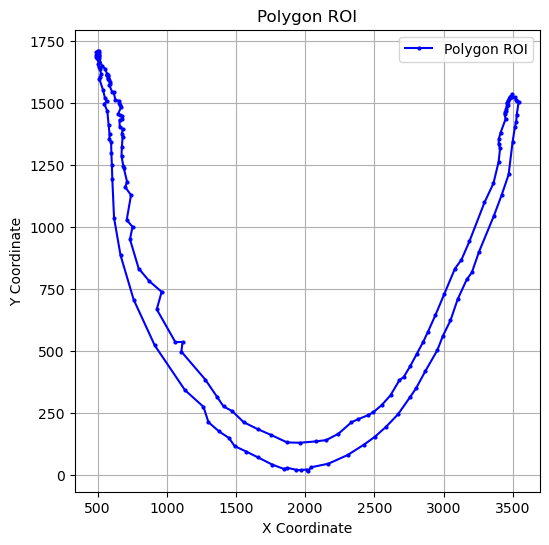

In [6]:
# Read the ROI coordinates from the CSV file
polygon_coords = pd.read_csv(ROI_filepath)

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


# Create a plot
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Polygon ROI', markersize=2)

# Close the polygon by connecting the last point to the first
plt.plot([x_coords.iloc[0], x_coords.iloc[-1]], [y_coords.iloc[0], y_coords.iloc[-1]], 'b-')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Polygon ROI")
plt.legend()
plt.grid(True)

In [7]:
level = 0
pixelsize = scalefactors[level]
image_chanel_0 = tifffile.imread(fullres_chanel_0, is_ome=False, level=level)


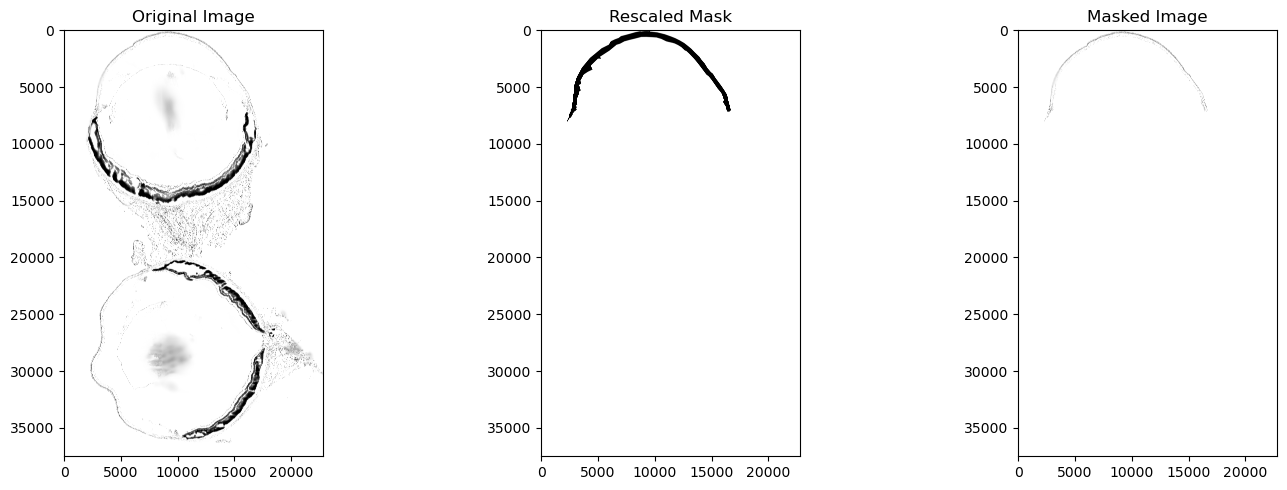

In [8]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_0 = np.zeros_like(image_chanel_0)
masked_image_0[mask_bool] = image_chanel_0[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_0, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_0, cmap='binary')
plt.title('Masked Image')
plt.axis('scaled')

plt.tight_layout()
plt.show()

In [9]:
image_chanel_2 = tifffile.imread(fullres_chanel_2, is_ome=False, level=level)


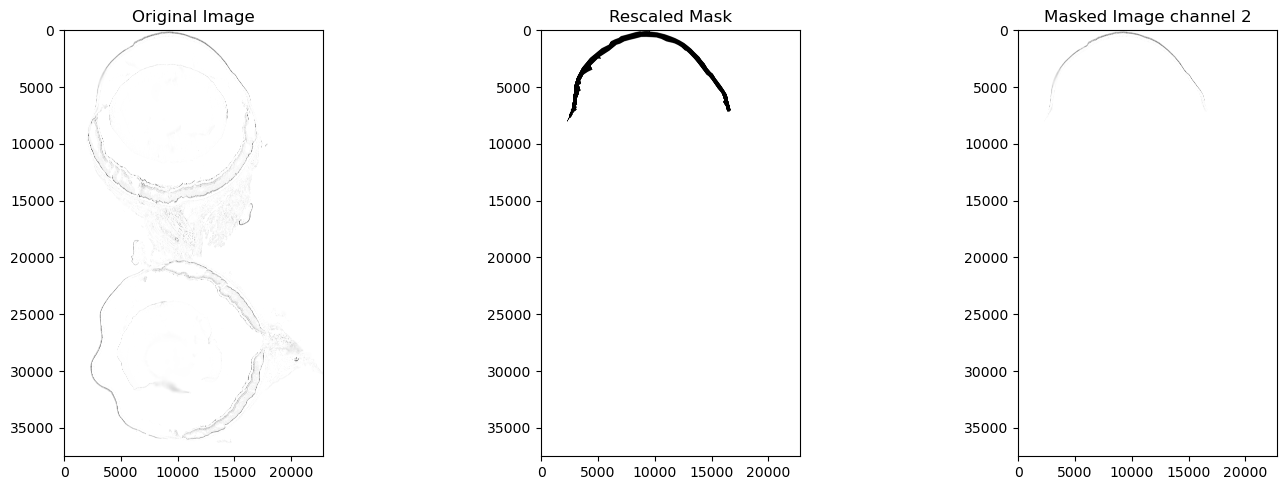

In [10]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_2 = np.zeros_like(image_chanel_2)
masked_image_2[mask_bool] = image_chanel_2[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_2, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_2, cmap='binary')
plt.title('Masked Image channel 2')
plt.axis('scaled')

plt.tight_layout()
plt.show()

In [11]:

def crop_polygon_to_overlapping_squares(polygon, square_size, overlap_size=40/0.2125):
    """
    Crops a polygon into overlapping square regions of a given size.

    Args:
        polygon (Polygon): The input polygon to crop.
        square_size (float): The base size of each square region (side length).
        overlap_size (float): The amount of overlap in um (default: 20).

    Returns:
        List[Polygon]: List of overlapping square polygons that fully contain the polygon.
    """
    # Get bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate grid of overlapping squares
    squares = []
    for x in range(int(minx), int(maxx), square_size):
        for y in range(int(miny), int(maxy), square_size):
            # Create expanded square with overlap
            # First vertex (x, y) remains the same
            # Other vertices are expanded by overlap_size
            square = box(
                x,                          # minx (unchanged)
                y,                          # miny (unchanged)
                x + square_size + overlap_size,  # maxx (expanded)
                y + square_size + overlap_size   # maxy (expanded)
            )
            # Check if the square intersects the polygon
            if polygon.intersects(square):
                squares.append(square)
    
    return squares

In [12]:
# Combine X and Y into coordinate pairs
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
print(rescaled_polygon_roi)

POLYGON ((2363.279668705882 7891.926164705883, 2384.145882352941 7841.847251764706, 2368.8439924705885 7801.5059058823535, 2384.535810352941 7753.737887058824, 2427.733056 7712.012997647059, 2474.4395524705883 7611.823534117647, 2436.8803679999996 7563.135703529412, 2414.623073411765 7511.202042352941, 2532.5874508235297 7316.575030588235, 2606.1285312941177 7147.202512941177, 2659.6686583529413 7090.311571764706, 2579.4496305882353 7044.869609411765, 2681.9259524705885 6908.543680000001, 2725.0494607058827 6650.266296470588, 2759.8264832941177 6467.107327058824, 2749.6252094117644 6381.3240188235295, 2810.832769411765 6317.334296470588, 2819.914928 6116.522983529412, 2837.0404065882353 5884.694724705882, 2852.2630545882353 5612.907044705883, 2910.833523294118 4877.689849411764, 3131.8717214117646 4167.052227294118, 3578.368813176471 3323.7918263529414, 4295.268285647059 2453.8454978823534, 5320.663628235294 1605.6500023529413, 5952.119167058824 1286.9649308235296, 6122.35792 993.37894

square: POLYGON ((5305.235294117647 71, 5305.235294117647 3082.235294117647, 2294 3082.235294117647, 2294 71, 5305.235294117647 71))
 x: array('d', [5305.235294117647, 5305.235294117647, 2294.0, 2294.0, 5305.235294117647]) 
 y: array('d', [71.0, 3082.235294117647, 3082.235294117647, 71.0, 71.0])
square: POLYGON ((5305.235294117647 2894, 5305.235294117647 5905.235294117647, 2294 5905.235294117647, 2294 2894, 5305.235294117647 2894))
 x: array('d', [5305.235294117647, 5305.235294117647, 2294.0, 2294.0, 5305.235294117647]) 
 y: array('d', [2894.0, 5905.235294117647, 5905.235294117647, 2894.0, 2894.0])
square: POLYGON ((5305.235294117647 5717, 5305.235294117647 8728.235294117647, 2294 8728.235294117647, 2294 5717, 5305.235294117647 5717))
 x: array('d', [5305.235294117647, 5305.235294117647, 2294.0, 2294.0, 5305.235294117647]) 
 y: array('d', [5717.0, 8728.235294117647, 8728.235294117647, 5717.0, 5717.0])
square: POLYGON ((8128.235294117647 71, 8128.235294117647 3082.235294117647, 5117 308

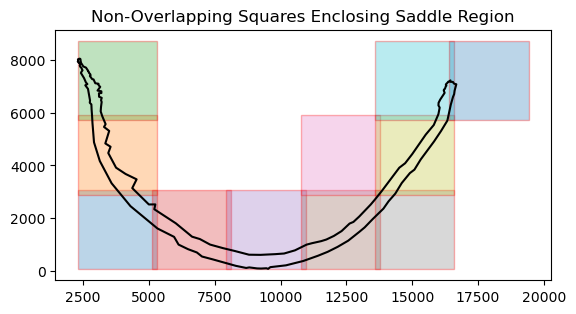

In [13]:
# Define square size
square_size = int(crop_size) # Adjust as necessary 


# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_overlapping_squares(rescaled_polygon_roi, square_size)

# Visualization
fig, ax = plt.subplots()
# Plot the original polygon
x, y = rescaled_polygon_roi.exterior.xy
ax.plot(x, y, 'k-', label="Saddle-shaped Polygon")  # Black for polygon

# Plot the square regions
for square in overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
    ax.fill(x, y, edgecolor='red', alpha=0.3, label="Red Square")

# Add labels and legend
ax.set_title(f"Non-Overlapping Squares Enclosing Saddle Region")
ax.set_aspect('equal', 'box')
# ax.legend(loc="upper left")
plt.show()

In [14]:
import os

# Define a function to crop the image based on a shapely Polygon
def crop_region(image, poly):
    """
    Crops the rectangular bounding box of a polygon from an image.

    Parameters:
        image (ndarray): The original image to crop.
        poly (Polygon): A shapely Polygon object defining the region.

    Returns:
        ndarray: The cropped image region.
    """
    # Get the bounding box of the polygon
    min_x, min_y, max_x, max_y = map(int, poly.bounds)
    
    # Crop the image using the bounding box
    cropped_image = image[min_y:max_y, min_x:max_x]
    
    return cropped_image


# Process and plot the square regions
for i, square in enumerate(overlapping_squares):
    print(f"Processing square {i + 1}:", square)
    
    # ch 0 Crop the region 
    cropped_image_sub = crop_region(masked_image_0, square)

    # ch2 Crop the region
    cropped_image_sub2 = crop_region(masked_image_2, square)

    cropped_image_sub_combined = np.stack((cropped_image_sub, cropped_image_sub2), axis=0)


    # Check if the folder exists, if not create it
    save_dir = f"{ddir}/cropped_image/{sample_name}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    # Save the cropped image
    save_path = f"{save_dir}/cropped_square_com_{i + 1}.tif"
    tifffile.imwrite(save_path, cropped_image_sub_combined)
    print(f"Cropped image saved to {save_path}")
    

Processing square 1: POLYGON ((5305.235294117647 71, 5305.235294117647 3082.235294117647, 2294 3082.235294117647, 2294 71, 5305.235294117647 71))
Created directory: G:\Alexis_data\Project\SpatialOmics_cellpose\results/cropped_image/1889od
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results/cropped_image/1889od/cropped_square_com_1.tif
Processing square 2: POLYGON ((5305.235294117647 2894, 5305.235294117647 5905.235294117647, 2294 5905.235294117647, 2294 2894, 5305.235294117647 2894))
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results/cropped_image/1889od/cropped_square_com_2.tif
Processing square 3: POLYGON ((5305.235294117647 5717, 5305.235294117647 8728.235294117647, 2294 8728.235294117647, 2294 5717, 5305.235294117647 5717))
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results/cropped_image/1889od/cropped_square_com_3.tif
Processing square 4: POLYGON ((8128.235294117647 71, 8128.235294117647 3082.235294117647, 5